In [1]:
import models.equibind as eq
from commons.process_mols import get_rec_graph, get_lig_graph_revised, get_receptor_inference, get_geometry_graph, distance_featurizer, rec_residue_featurizer
import rdkit.Chem as Chem
import inference_further_mods as inf
from train import load_model
import torch
import math
import numpy as np
from scipy.special import softmax
import dgl
import scipy.spatial as spa
from commons.geometry_utils import random_rotation_translation
import re
from models.equibind import EquiBind
from commons.utils import seed_all
import random
from rdkit.Geometry import Point3D
import py3Dmol
from futils.loaders import load_bulk2
import matplotlib.pyplot as plt
import pandas as pd
import importlib

In [7]:
args = inf.parse_arguments(["--config", "configs_clean/unit_test_sdf.yml"])
args = inf.get_default_args(args)
dp = args.dataset_params
use_rdkit_coords = args.use_rdkit_coords
device = args.device
checkpoint = torch.load(args.checkpoint, map_location=device)

rec_path = "/home/amfaber/cyp_screen/protein.pdb"

rec, rec_coords, c_alpha_coords, n_coords, c_coords = get_receptor_inference(rec_path)
max_neighbor=dp['c_alpha_max_neighbors']
cutoff=dp['rec_graph_radius']

In [44]:
seed_all(1)

[2022-05-12 09:04:37.730763] [ Using Seed :  1  ]


In [42]:
model = EquiBind(device = device, lig_input_edge_feats_dim = 15, rec_input_edge_feats_dim = 27, **args.model_parameters)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
pass

In [45]:
print(torch.rand(1))
print(np.random.random())
print(dgl.random.choice(10**3,1))
print(random.random())

tensor([0.7576])
0.417022004702574
tensor([0])
0.13436424411240122


In [37]:
torch.tensor([0.7576])
0.417022004702574
torch.tensor([0])
0.13436424411240122

0.13436424411240122

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
dgl.random.seed(seed)
random.seed(seed)

In [124]:
rec_path = "/home/amfaber/equibind/data/PDBBind_processed/1a0q/1a0q_protein_processed.pdb"
rec, rec_coords, c_alpha_coords, n_coords, c_coords = get_receptor_inference(rec_path)

In [43]:
rec_graph = get_rec_graph(rec, rec_coords, c_alpha_coords, n_coords, c_coords,
                                    use_rec_atoms=dp['use_rec_atoms'], rec_radius=dp['rec_graph_radius'],
                                    surface_max_neighbors=dp['surface_max_neighbors'],
                                    surface_graph_cutoff=dp['surface_graph_cutoff'],
                                    surface_mesh_cutoff=dp['surface_mesh_cutoff'],
                                    c_alpha_max_neighbors=dp['c_alpha_max_neighbors'])

In [170]:
ligs = [mol for mol in Chem.SDMolSupplier("/home/amfaber/cyp_screen/test_3D_opt_1216.sdf")]
lig_graphs = [get_lig_graph_revised(lig, "name", max_neighbors=dp['lig_max_neighbors'],
                                            use_rdkit_coords=False, radius=dp['lig_graph_radius']) for lig in ligs[:100]]

geometry_graphs = [get_geometry_graph(lig).to(device) for lig in ligs[:100]]

for lig_graph in lig_graphs:
    rot_T, rot_b = random_rotation_translation(translation_distance=5)
    if (use_rdkit_coords):
        lig_coords_to_move = lig_graph.ndata['new_x']
    else:
        lig_coords_to_move = lig_graph.ndata['x']
    mean_to_remove = lig_coords_to_move.mean(dim=0, keepdims=True)
    input_coords = (rot_T @ (lig_coords_to_move - mean_to_remove).T).T + rot_b
    lig_graph.ndata['new_x'] = input_coords


RDKit WARNING: [10:44:35] Warning: molecule is tagged as 3D, but all Z coords are zero
[10:44:35] Warning: molecule is tagged as 3D, but all Z coords are zero


In [189]:

def translatemol(mol, translation, conformer = 0):
    conf = mol.GetConformer(conformer)
    positions = conf.GetPositions()
    positions += translation
    for i, position in enumerate(positions):
        conf.SetAtomPosition(i, Point3D(*position))

In [11]:
mol = ligs[0]
mol.GetProp("_Name")

'Pyridoxal Phosphate'

In [9]:
ligs = [mol for mol in Chem.SDMolSupplier("/home/amfaber/cyp_screen/test_3D_opt_1216.sdf")]
ligs[0].GetConformer(0).GetPositions()

RDKit WARNING: [13:00:03] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:00:03] Warning: molecule is tagged as 3D, but all Z coords are zero


array([[ 3.5876, -0.0408,  0.3993],
       [ 1.926 , -0.423 ,  0.4598],
       [-3.2638,  0.4447,  1.3958],
       [ 3.8041,  1.6331,  0.2655],
       [ 4.328 , -0.5828,  1.8205],
       [ 0.4199,  2.0199,  1.2909],
       [ 4.2343, -0.7276, -0.7827],
       [-2.0661, -1.3389, -1.5581],
       [-0.1787, -0.1899, -0.6285],
       [-1.0073,  0.3094,  0.4138],
       [ 1.3054,  0.0892, -0.6964],
       [-2.3799, -0.0412,  0.4255],
       [-2.8852, -0.8844, -0.5768],
       [-0.7512, -1.0158, -1.6083],
       [-4.3317, -1.2746, -0.5948],
       [-0.4599,  1.1464,  1.5085]])

In [216]:
ligs = [mol for mol in Chem.SDMolSupplier("/home/amfaber/cyp_screen/test_3D_opt_1216.sdf")]
lig = ligs[0]


RDKit WARNING: [11:26:25] Warning: molecule is tagged as 3D, but all Z coords are zero
[11:26:25] Warning: molecule is tagged as 3D, but all Z coords are zero


In [191]:
translation = np.array([10, 0, 0])

[translatemol(mol, translation) for mol in ligs]
with Chem.SDWriter("translated_10_along_x.sdf") as writer:
    [writer.write(mol) for mol in ligs]

In [176]:
print(Chem.MolToMolBlock(ligs[0]))

Pyridoxal Phosphate
     RDKit          3D

 16 16  0  0  0  0  0  0  0  0999 V2000
   13.5876   -0.0408    0.3993 P   0  0  0  0  0  0  0  0  0  0  0  0
   11.9260   -0.4230    0.4598 O   0  0  0  0  0  0  0  0  0  0  0  0
    6.7362    0.4447    1.3958 O   0  0  0  0  0  0  0  0  0  0  0  0
   13.8041    1.6331    0.2655 O   0  0  0  0  0  0  0  0  0  0  0  0
   14.3280   -0.5828    1.8205 O   0  0  0  0  0  0  0  0  0  0  0  0
   10.4199    2.0199    1.2909 O   0  0  0  0  0  0  0  0  0  0  0  0
   14.2343   -0.7276   -0.7827 O   0  0  0  0  0  0  0  0  0  0  0  0
    7.9339   -1.3389   -1.5581 N   0  0  0  0  0  0  0  0  0  0  0  0
    9.8213   -0.1899   -0.6285 C   0  0  0  0  0  0  0  0  0  0  0  0
    8.9927    0.3094    0.4138 C   0  0  0  0  0  0  0  0  0  0  0  0
   11.3054    0.0892   -0.6964 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.6201   -0.0412    0.4255 C   0  0  0  0  0  0  0  0  0  0  0  0
    7.1148   -0.8844   -0.5768 C   0  0  0  0  0  0  0  0  0  0  0  0
    9.

In [5]:
load_once_data = load_bulk2("/home/amfaber/equibind/load_once_gnina.txt")
#reload_data = load_bulk2("/home/amfaber/equibind/cypscreen_gnina.txt")
translated_data = load_bulk2("/home/amfaber/equibind/translated_gnina.txt")
dumb_data = load_bulk2("/home/amfaber/equibind/dumb_gnina.txt")

In [25]:
dumb_data = dumb_data.iloc[load_once_data.index]

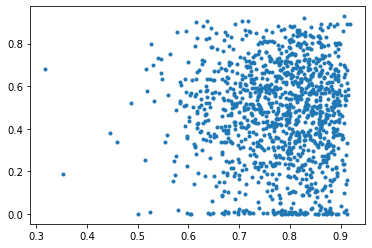

In [28]:
plt.plot(dumb_data.CNNscore, load_once_data.CNNscore, ".")

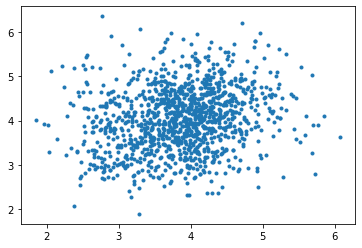

In [29]:
plt.plot(dumb_data.CNNaffinity, load_once_data.CNNaffinity, ".")

In [198]:
print(dumb_data.CNNscore.mean())
print(translated_data.CNNscore.mean())

0.7774811687242799
0.8052137366255143


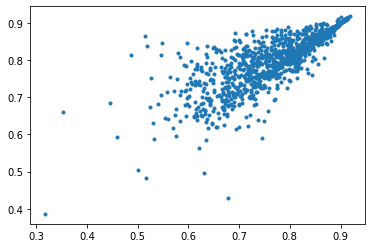

In [199]:
plt.plot(dumb_data.CNNscore, translated_data.CNNscore, ".")

In [201]:
dumb_data.CNNaffinity

0       3.12613
1       2.92424
2       2.77876
3       2.52450
4       3.44803
         ...   
1210    3.93433
1211    3.26680
1212    4.17075
1213    4.38954
1214    5.13474
Name: CNNaffinity, Length: 1215, dtype: float64

In [206]:
indices = []
with open("/home/amfaber/equibind/data/results/unit_test/failed.txt") as file:
    lines = file.readlines()
    for line in lines:
        indices.append(int(line.split()[0]))

In [213]:
indices

[186, 214, 397, 804, 973, 977, 992, 998, 1051, 1167, 1187]

In [214]:
"1051"

'1051'

In [209]:
load_once_data

,Affinity,RMSD,CNNscore,CNNaffinity,CNNvariance
0,38.62427,1.56648,0.01668,2.83790,0.48300
1,-1.30736,7.68524,0.34334,3.73651,0.09872
2,-3.29877,5.41407,0.39026,2.69370,0.12786
3,-2.28624,5.48663,0.35660,2.70832,0.15356
4,-3.57964,7.24013,0.36294,3.77483,0.03975
...,...,...,...,...,...
1200,-3.77239,5.08395,0.42092,4.19442,0.14099
1201,-1.89935,7.70605,0.42754,3.28424,0.72305
1202,1.28221,10.67422,0.61828,4.47954,0.29119
1203,77.99104,3.34422,0.00935,3.52069,1.36106


In [210]:
dumb_data.drop(indices)

,Affinity,RMSD,CNNscore,CNNaffinity,CNNvariance
0,-0.00269,0.52667,0.80086,3.12613,0.48702
1,0.00000,0.16550,0.86657,2.92424,0.50314
2,-1.13255,7.27561,0.71418,2.77876,0.13787
3,-0.26932,4.69477,0.84722,2.52450,0.25661
4,-0.42930,4.28503,0.82325,3.44803,0.67477
...,...,...,...,...,...
1210,-0.60693,4.05761,0.81840,3.93433,1.00507
1211,-1.06060,5.88918,0.69919,3.26680,0.21383
1212,-0.01748,0.47794,0.79729,4.17075,0.26672
1213,-0.96432,3.58069,0.72942,4.38954,0.24661


ValueError: x and y must have same first dimension, but have shapes (1215,) and (1205,)

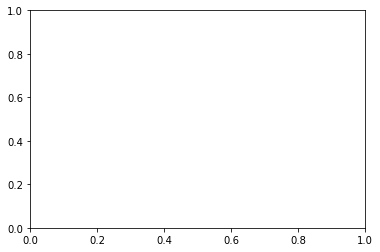

In [202]:
plt.plot(dumb_data.CNNaffinity, load_once_data.CNNaffinity)

(array([  5.,  34., 131., 199., 289., 270., 179.,  67.,  24.,   7.]),
 array([1.88662 , 2.333975, 2.78133 , 3.228685, 3.67604 , 4.123395,
        4.57075 , 5.018105, 5.46546 , 5.912815, 6.36017 ]),
 <BarContainer object of 10 artists>)

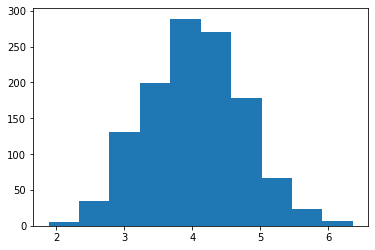

In [62]:
plt.hist(load_once_data.CNNaffinity)

(array([  4.,  23., 113., 210., 285., 281., 195.,  61.,  28.,   5.]),
 array([1.72965 , 2.203356, 2.677062, 3.150768, 3.624474, 4.09818 ,
        4.571886, 5.045592, 5.519298, 5.993004, 6.46671 ]),
 <BarContainer object of 10 artists>)

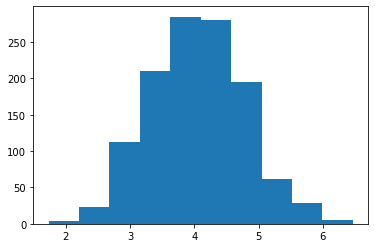

In [63]:
plt.hist(reload_data.CNNaffinity)

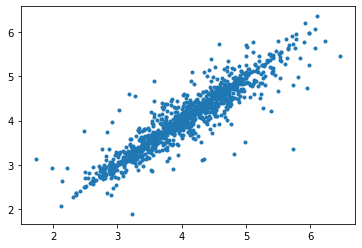

In [67]:
plt.plot(reload_data.CNNaffinity, load_once_data.CNNaffinity, ".")

In [74]:
load_once_data.CNNaffinity

0       2.83790
1       3.73651
2       2.69370
3       2.70832
4       3.77483
         ...   
1200    4.19442
1201    3.28424
1202    4.47954
1203    3.52069
1204    5.16753
Name: CNNaffinity, Length: 1205, dtype: float64

In [79]:
((reload_data.CNNaffinity - load_once_data.CNNaffinity).abs() < 0.01).sum()

228

In [ ]:
plt.plot(reload_data.CNNaffinity, load_once_data.CNNaffinity, ".")

In [243]:
fp = "/home/amfaber/equibind/load_once_gnina.txt"
out = {}
with open(fp) as file:
    s = file.read()
s = s.split("---BEGIN DATA---\n")[1]
s = s.split("## ")[1:]
for mol in s:
    mol = re.split(" |\n", mol, 2)
    idx, name = mol[:2]
    idx = int(idx)
    out[idx] = {}
    for match in re.findall("[a-zA-Z]+: -?[0-9]+\.?[0-9]*", mol[2]):
        key, val = match.split(": ")
        val = float(val)
        out[idx][key] = val
pd.DataFrame(out).T

,Affinity,RMSD,CNNscore,CNNaffinity,CNNvariance
2,-1.30736,7.68524,0.34334,3.73651,0.09872
0,-3.57964,7.24013,0.36294,3.77483,0.03975
3,-2.28624,5.48663,0.35660,2.70832,0.15356
5,-3.29877,5.41407,0.39026,2.69370,0.12786
4,-4.67143,6.30009,0.28671,3.09066,0.41060
...,...,...,...,...,...
1200,-3.77239,5.08395,0.42092,4.19442,0.14099
1201,-1.89935,7.70605,0.42754,3.28424,0.72305
1202,1.28221,10.67422,0.61828,4.47954,0.29119
1203,77.99104,3.34422,0.00935,3.52069,1.36106


In [242]:
pd.DataFrame(out).T

,Affinity,RMSD,CNNscore,CNNaffinity,CNNvariance
2,-1.30736,7.68524,0.34334,3.73651,0.09872
0,-3.57964,7.24013,0.36294,3.77483,0.03975
3,-2.28624,5.48663,0.35660,2.70832,0.15356
5,-3.29877,5.41407,0.39026,2.69370,0.12786
4,-4.67143,6.30009,0.28671,3.09066,0.41060
...,...,...,...,...,...
1200,-3.77239,5.08395,0.42092,4.19442,0.14099
1201,-1.89935,7.70605,0.42754,3.28424,0.72305
1202,1.28221,10.67422,0.61828,4.47954,0.29119
1203,77.99104,3.34422,0.00935,3.52069,1.36106


In [259]:
from futils.loaders import load_bulk2

ImportError: cannot import name 'load_bulk2' from 'futils.loaders' (/home/amfaber/python_scripts/futils/loaders.py)

In [55]:
fp = "/home/amfaber/equibind/load_once_gnina.txt"
out = {}
with open(fp) as file:
    s = file.read()
for match in re.findall("[a-zA-Z]+: -?[0-9]+\.?[0-9]*", s):
    key, value = match.split(": ")
    try:
        out[key].append(float(value))
    except KeyError:
        out[key] = [float(value)]


(array([  9.,  53., 114., 181., 288., 326., 160.,  61.,  16.,   7.]),
 array([1.84742 , 2.270442, 2.693464, 3.116486, 3.539508, 3.96253 ,
        4.385552, 4.808574, 5.231596, 5.654618, 6.07764 ]),
 <BarContainer object of 10 artists>)

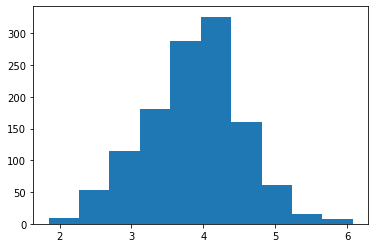

In [82]:
plt.hist(dumb_data.CNNaffinity)

(array([  2.,   0.,   3.,  13.,  49., 114., 190., 261., 335., 248.]),
 array([0.31819 , 0.378201, 0.438212, 0.498223, 0.558234, 0.618245,
        0.678256, 0.738267, 0.798278, 0.858289, 0.9183  ]),
 <BarContainer object of 10 artists>)

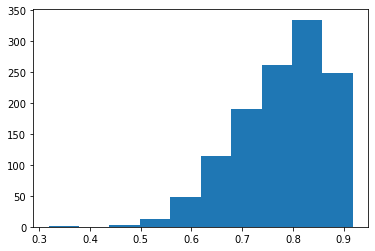

In [83]:
plt.hist(dumb_data.CNNscore)

(array([106.,  66., 100., 137., 166., 160., 186., 150.,  93.,  41.]),
 array([1.00000e-05, 9.33980e-02, 1.86786e-01, 2.80174e-01, 3.73562e-01,
        4.66950e-01, 5.60338e-01, 6.53726e-01, 7.47114e-01, 8.40502e-01,
        9.33890e-01]),
 <BarContainer object of 10 artists>)

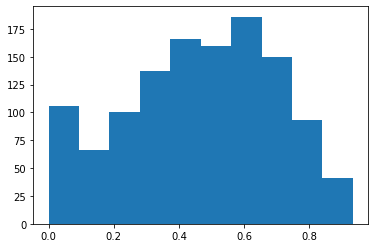

In [84]:
plt.hist(reload_data.CNNscore)

(array([107.,  69.,  98., 127., 150., 187., 189., 142.,  85.,  51.]),
 array([1.00000e-05, 9.28860e-02, 1.85762e-01, 2.78638e-01, 3.71514e-01,
        4.64390e-01, 5.57266e-01, 6.50142e-01, 7.43018e-01, 8.35894e-01,
        9.28770e-01]),
 <BarContainer object of 10 artists>)

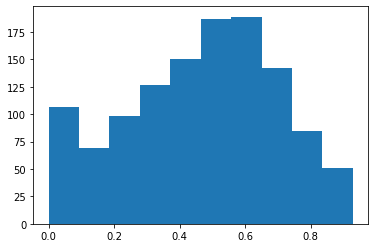

In [85]:
plt.hist(load_once_data.CNNscore)